# Datasets and libraries loading

In [3]:
# General
import numpy as np
import pandas as pd

import gzip
import zipfile
import shutil

import collections
from tqdm.notebook import tqdm

# Graph manipulation
import networkx as nx

# Metrics and properties
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import dijkstra
from sklearn.linear_model import LinearRegression

# GO libraries (if missing, use "pip install goatools==1.3.9")
from goatools.obo_parser import GODag
from goatools.associations import read_gaf
from goatools.go_enrichment import GOEnrichmentStudy

# Visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')

In [4]:
# Load all the downloaded files

# STRING interactions
with gzip.open("datasets/interactions.txt.gz", "rt", encoding = "utf-8") as f:
    df = pd.read_csv(f, sep = ' ')

# From STRING IDs to gene IDs file
with gzip.open("datasets/mapping.txt.gz", "rt", encoding = "utf-8") as f:
    string_2_gene = pd.read_csv(f, sep = '\t')

# From IDs to UniProt IDs file
with open("datasets/PTHR18.0_human", "r") as f:
    gene_2_uniprot = pd.read_csv(f, sep = "\t", header = None)

# HDA
with zipfile.ZipFile("datasets/pathology.tsv.zip", "r") as z:
    with z.open("pathology.tsv", "r") as f:
        pathology = pd.read_csv(f, sep="\t", encoding="utf-8")

# Swiss-Prot
with gzip.open("datasets/uniprot_sprot.fasta.gz", "rb") as f_in:
    with open("datasets/uniprot_sprot.fasta", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

with open("datasets/uniprot_sprot.fasta", "r") as f:
    lines = f.readlines()

swiss_prots = [line.split("|")[1] for line in lines if line[0] == ">"]

# Decompress the gz file
with gzip.open("datasets/goa_human.gaf.gz", "rb") as f_in:
    with open("datasets/goa_human.gaf", "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

# Load Pharos TDLs
tdl = {UniProt : TDL for UniProt, TDL in pd.read_csv("datasets/datasets/TCRDv6.1.0_ALLexp.csv")[["UniProt", "TDL"]].values}

# Load the GO files
obodag = GODag("datasets/go-basic.obo")
gene2go = read_gaf("datasets/goa_human.gaf")

go-basic.obo: fmt(1.2) rel(2023-11-15) 46,228 Terms
HMS:0:00:25.710258 635,268 annotations READ: goa_human.gaf 
17580 IDs in loaded association branch, BP


# Functions defining

In [5]:
# Defining some useful functions

# Robustness analysis
def robustness_analysis(G, removal = 'random', metric = "connection", fraction = 0.05):
    """
    Evaluate the robustness of a graph under different node removal strategies and metrics.

    Parameters:
    -----------
    G : NetworkX graph
        The original graph to be analyzed.

    removal : str, optional
        The strategy for node removal. Can be either 'random' or 'targeted'.
        Default is 'random'.

    metric : str, optional
        The metric used to evaluate robustness. Can be either 'connection' or 'density'.
        Default is 'connection'.

    fraction : float, optional
        The fraction of nodes to be removed from the graph.
        Default is 0.05.

    Returns:
    --------
    float
        The robustness metric value. For 'connection', it is the normalized size of the largest
        connected component. For 'density', it is the relative density of the graph.

    Function Overview:
    ------------------
    1. Creates a copy of the original graph to ensure it remains unaltered.
    2. Removes nodes based on the specified strategy ('random' or 'targeted').
    3. Calculates the robustness metric based on the specified metric ('connection' or 'density').

    Example:
    --------
    >>> G = nx.erdos_renyi_graph(100, 0.1)
    >>> robustness_analysis(G, removal='random', metric='connection', fraction=0.1)
    """
    G_copy = G.copy()

    # Nodes to remove
    num_remove = int(fraction * len(G))

    # Random nodes removing
    if removal == 'random':
        nodes_to_remove = np.random.choice(G.nodes(), num_remove, replace = False)
    # Nodes removal starting from the hub
    elif removal == 'targeted':
        nodes_to_remove = [node for node in degree_sort["Vertex"].values[:num_remove]] # Use the hubs dataframe defined above

    G_copy.remove_nodes_from(nodes_to_remove)

    if metric == "connection":
        # Calculate the biggest connected component
        largest_cc = max(nx.connected_components(G_copy), key = len)

        return len(largest_cc) / len(G)

    elif metric == "density":
        # Density calculation for both graphs
        density_original = nx.density(G)
        density_copy = nx.density(G_copy)

        # Calculate the relative density
        relative_density = density_copy / density_original if density_original != 0 else 0

        return relative_density

# Subgraph generation
def subgraph_of_nodes_and_neighbors(G, nodes, depth):
    """
    Generate a subgraph from a given set of nodes and their neighbors up to a specified depth.

    Parameters:
    -----------
    G : NetworkX graph
        The original graph from which the subgraph will be extracted.

    nodes : list
        The list of nodes that serve as the starting point for the subgraph.

    depth : int
        The depth up to which neighbors should be included in the subgraph.

    Returns:
    --------
    NetworkX graph
        The resulting subgraph containing the specified nodes and their neighbors up to the given depth.

    Function Overview:
    ------------------
    1. Checks the base case where depth is zero and returns the subgraph of the given nodes.
    2. Identifies the neighbors of the given nodes.
    3. Recursively calls itself to expand the subgraph up to the specified depth.

    Example:
    --------
    >>> G = nx.erdos_renyi_graph(100, 0.1)
    >>> nodes = [1, 2, 3]
    >>> subgraph = subgraph_of_nodes_and_neighbors(G, nodes, 2)
    """
    # Base case
    if depth == 0:
        return G.subgraph(nodes)

    # Get the neighbors
    neighbors = set(nodes)
    for node in nodes:
        neighbors.update(G.neighbors(node))

    # Recursion
    return subgraph_of_nodes_and_neighbors(G, list(neighbors), depth - 1)

In [6]:
# Select and rename the columns for the mapping process
gene_2_uniprot[["From", "To"]] = gene_2_uniprot[[2, 1]]
gene_2_uniprot = gene_2_uniprot[["From", "To"]]

# mapping datasets building
id_mapping_1 = {string_id : gene_name for string_id, gene_name in string_2_gene[["#string_protein_id", "preferred_name"]].values}
id_mapping_2 = {gene_name : uniprot_id for gene_name, uniprot_id in gene_2_uniprot[["From", "To"]].values}

# Pre-processing

In [7]:
# Filtering only the rows (links) with very high confidence, i.e., combined score >= 900), according to the threesholds of STRING
confidence_thr = 0.9
df = df[df["combined_score"] >= confidence_thr * 1000]

# Removed number and fraction
removed = (df["combined_score"] <= confidence_thr * 1000).sum()
print("Removed (based on an accuracy filter of {}): {} ({} %)".format(confidence_thr, removed, round(removed / df.shape[0] * 100, 2)))

Removed (based on an accuracy filter of 0.9): 16060 (17.87 %)


# Graph building and early EDA

In [8]:
G = nx.from_pandas_edgelist(df, 'protein1', 'protein2')

# The adjacency matrix is symmetric
is_directed = G.is_directed()

if is_directed:
    print("The graph is directed")
else:
    print("The graph is undirected")

The graph is undirected


In [9]:
# Nodes and edges
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print("Number of nodes: {}".format(num_nodes))
print("Number of edges: {}".format(num_edges))

Number of nodes: 8706
Number of edges: 44931


# Connected components analysis

In [10]:
# Built-in NetworkX function for calculating the connected components
conn_comp = list(nx.connected_components(G)) # A list is used to avoid the re-instantiation of the generator

# Number of connected components
number_of_connected_components = len(conn_comp)

# Size for each connected component
component_sizes = [len(component) for component in conn_comp]
ccs = pd.DataFrame(collections.Counter(component_sizes).items(),
                   columns = ("size", "occurrences")).sort_values("size", ascending = False).reset_index(drop = True)

In [11]:
print("Number of connected components: {}".format(number_of_connected_components))

Number of connected components: 524


In [12]:
print("Connected components and their numerosity")
ccs

Connected components and their numerosity


,size,occurrences
0,7167,1
1,17,1
2,16,2
3,12,4
4,11,1
5,10,3
6,9,1
7,8,6
8,7,7
9,6,10


In [13]:
# Calculate how many nodes are not in the biggest connected component
biggest_cc_nodes = ccs.iloc[0, 0] * ccs.iloc[0, 1]
ext_nodes = ccs.iloc[1:, :].sum().sum()

print("Removed nodes: {} ({} %)".format(ext_nodes, round(ext_nodes / biggest_cc_nodes * 100, 2)))

Removed nodes: 633 (8.83 %)


In [14]:
# Sort the connected components by size and select and extract the biggest conneceted component
components_sorted = sorted(conn_comp, key = len, reverse = True)
largest_component = components_sorted[0]
G = G.subgraph(largest_component)

# Now that the final graph has been obtained, it is possible to rename the ndoes for getting UniProt IDs
G = nx.relabel_nodes(G, id_mapping_1) # STRING IDs --> Gene IDs

# Exploratory Data Analysis

## Statistics powered by NetowrkX

In [15]:
# Calculate degree values, number of nodes and edges (updated after graph shrinking) and extract them from the graph
nodes = list(G.nodes)
edges = list(G.edges)

degrees = list(dict(G.degree()).values())

num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

# Graph Density
density = nx.density(G)

# Average Degree
avg_degree = sum(dict(G.degree()).values()) / len(G)

# Clustering Coefficient
avg_clustering_coefficient = nx.average_clustering(G)

# Approximated betweenness centrality (average value) (exact betweenness centrality is too slow)
betweenness_vals = nx.approximate_current_flow_betweenness_centrality(G)
avg_betweenness = np.array(list(betweenness_vals.values())).mean()

In [16]:
print("Number of nodes: {}".format(num_nodes))
print("Number of edges: {}".format(num_edges))

print("Density: {}\nAverage degree: {}\nAverage clustering coefficient: {}\nAverage betweenness centrality: {}"
.format(
    round(density, 4),
    round(avg_degree, 4),
    round(avg_clustering_coefficient, 4),
    round(avg_betweenness, 4)
))

Number of nodes: 7167
Number of edges: 43180
Density: 0.0017
Average degree: 12.0497
Average clustering coefficient: 0.4845
Average betweenness centrality: 0.0016


## Statistics based on the CSR adjacency matrix

In [17]:
# NetworkX can be too slow on some calcualtions, since the graph is too big
# Making and using the adjacency matrix for calculating some measures can bring to faster results
# Since the adjacency matrix has a very high sparsity,
# it is possible to make calculations even faster using a CSR form
am = nx.to_numpy_array(G)
am_sparse = csr_matrix(am)

sparsity_score = 1 - np.sum(am) / (am.shape[0] ** 2)

# Calculate distances (useful for calculating diameter and average shortest path length)
# Since there is one single connected component, ditances must be all finite
distances = dijkstra(am_sparse, unweighted=True)

# Average Distance
avg_dist = np.mean(distances) / 2

# Maximum distance
diameter = int(np.max(distances))

In [18]:
print("Sparsity score: {}\nAverage distance: {}\nDiameter: {}"
.format(
    round(sparsity_score, 4),
    round(avg_dist, 4),
    diameter,
))

Sparsity score: 0.9983
Average distance: 2.7713
Diameter: 18


# Degree distribution analysis

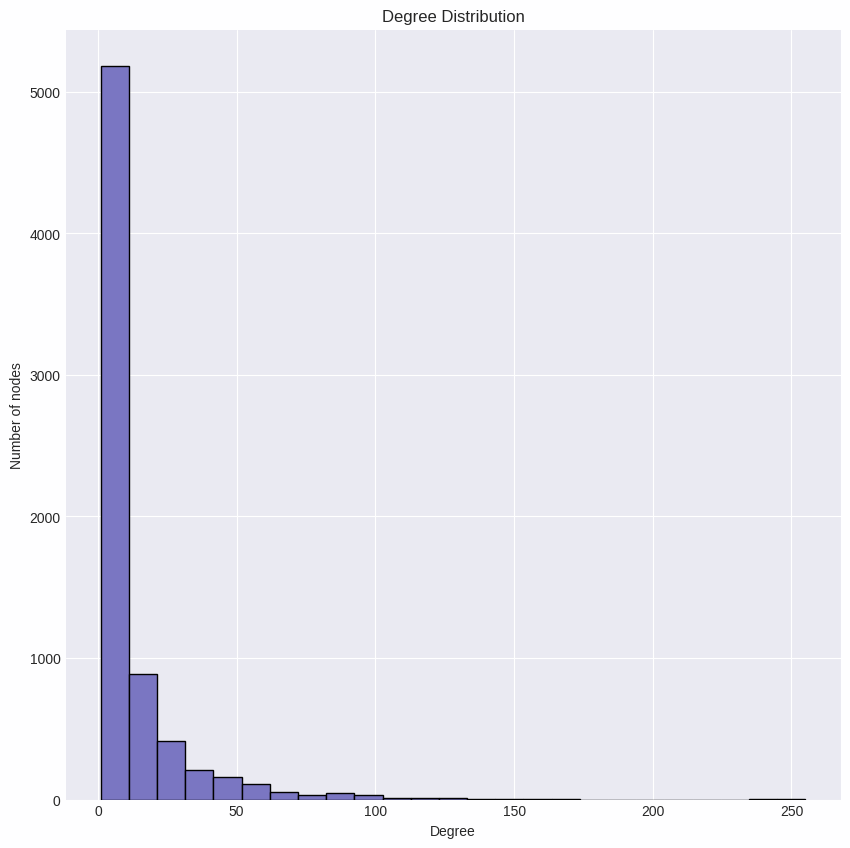

In [19]:
# Plot histogram ("Raw" degree distribution)
plt.figure(figsize = (10, 10))
plt.hist(degrees, bins =25, edgecolor = 'black')
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.show()

In [20]:
# Sort the degrees
sorted_degrees = np.sort(degrees)

# Calculate the dictionary degree vs number of nodes with such degree
d_count = collections.Counter(degrees)

# Order the dictionary by key and split the items in two lists
d_count_sorted = collections.OrderedDict(sorted(d_count.items())) # Order by key
sorted_degrees_unique = list(d_count_sorted.keys())
frequencies = list(d_count_sorted.values())

# Make a log-log scale
sorted_degrees_log = np.log(np.array(sorted_degrees_unique))
frequencies_log = np.log(np.array(frequencies))

# Analyze all the sorted degrees set for testing any possible k_min
gammas = list()

for k_min in tqdm(range(len(sorted_degrees_log))):
    # Sets preparation
    X_subset = sorted_degrees_log[k_min:].reshape(-1, 1)
    y_subset = frequencies_log[k_min:].reshape(-1, 1)

    # Linear interpolation
    reg = LinearRegression().fit(X_subset, y_subset)
    y_pred = reg.predict(X_subset)

    # Coefficient appending
    gamma = reg.coef_[0][0]
    gammas.append(gamma)

gammas = np.array([-gamma for gamma in gammas])

  0%|          | 0/127 [00:00<?, ?it/s]

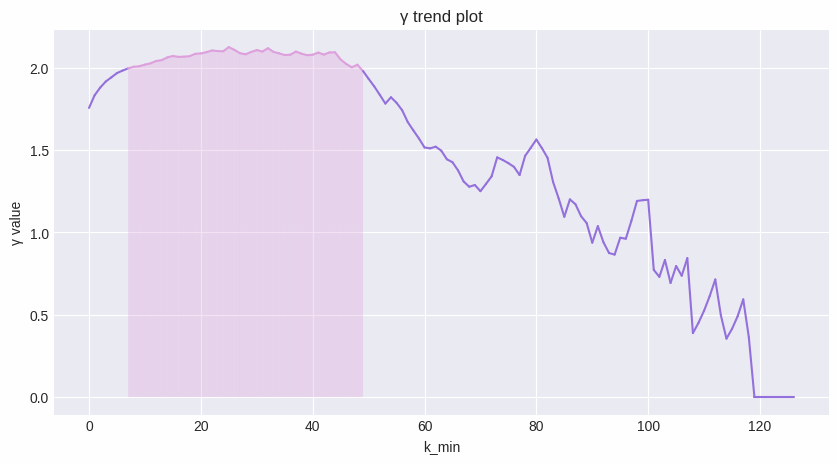

In [21]:
# Identify the segment that must be highlighted (for 2 <= gamma <= 3)
mask = (np.array(gammas) >= 2) & (np.array(gammas) <= 3)

plt.figure(figsize = (10, 5))

for i in range(len(gammas) - 1):
    if mask[i] or mask[i + 1]:
        color = 'plum'
    else:
        color = 'mediumpurple'

    plt.plot(range(i, i + 2), gammas[i : i + 2], color = color)

    # Filling part for the "within-range"
    if mask[i] or mask[i + 1]:
        plt.fill_between(range(i, i + 2), 0, gammas[i : i + 2], color = 'plum', alpha = 0.3, edgecolor = 'none')

plt.xlabel("k_min")
plt.ylabel("γ value")
plt.title("γ trend plot")
plt.show()

In [22]:
nice_gammas = gammas[mask] # Find the good gammas
gamma_where = np.where(mask) # Find the good gammas' indices

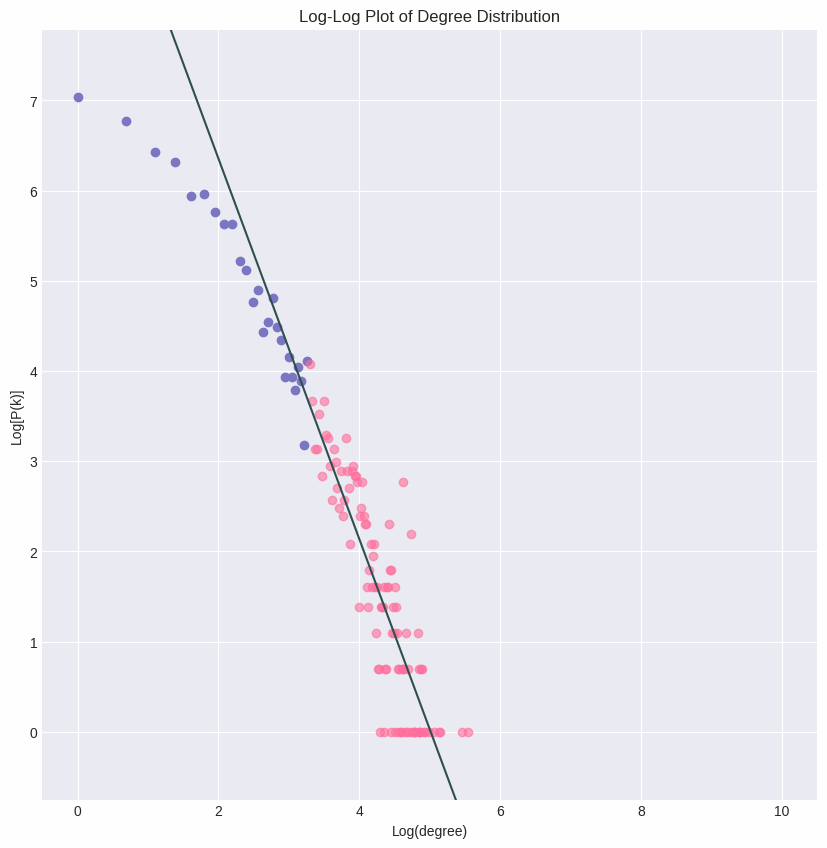

In [23]:
# Take the optimal k_min as the one corresponding to the gammas that is the closest to 2.5
k_min_index = np.argmin((abs(gammas - 2.5)) + 2.5)
k_min_optimal = sorted_degrees_unique[k_min_index]

# Final linear model training with k_min_optimal
X = sorted_degrees_log[k_min_optimal:].reshape(-1, 1)
y = frequencies_log[k_min_optimal:].reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Calculate coefficient and intercept
coefficient = reg.coef_[0][0]
intercept = reg.intercept_[0]

# Plot the interpolation line (points after k_min are highlighted)
plt.figure(figsize = (10, 10))

plt.scatter(sorted_degrees_log[:k_min_optimal], frequencies_log[:k_min_optimal]) # Before k_min
plt.scatter(sorted_degrees_log[k_min_optimal:], frequencies_log[k_min_optimal:]) # After k_min
plt.plot(np.linspace(0, 10, 100), coefficient * np.linspace(0, 10, 100) + intercept, color = "darkslategray")

plt.ylim(frequencies_log.min() - 0.75, frequencies_log.max() + 0.75)

plt.title("Log-Log Plot of Degree Distribution")
plt.xlabel("Log(degree)")
plt.ylabel("Log[P(k)]")

plt.show()

<ipython-input-24-b18e629c5786>:9: RuntimeWarning: divide by zero encountered in log
  ccdf_log = np.log(ccdf)


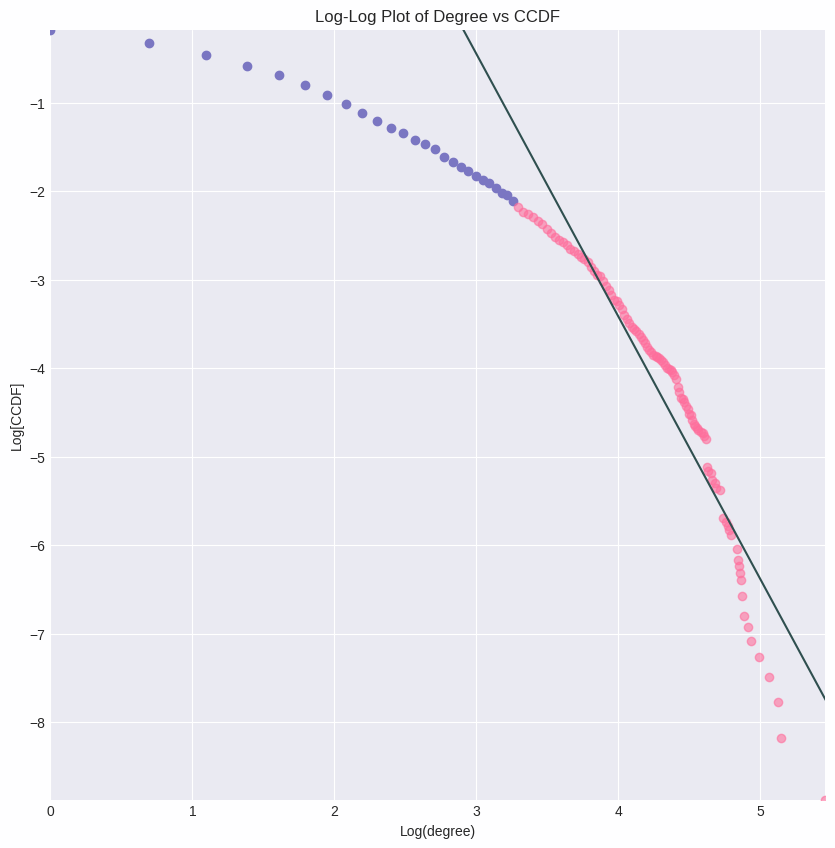

In [24]:
# CCDF calculation
sorted_degrees_unique = np.unique(sorted_degrees)
ccdf = np.array([np.sum(sorted_degrees > k) for k in sorted_degrees_unique]) / len(degrees)

# Exclude zero positions
mask_no_zeros = (sorted_degrees_unique != 0) & (ccdf != 0)

sorted_degrees_log = np.log(sorted_degrees_unique)
ccdf_log = np.log(ccdf)

# Final linear model training with k_min_optimal

sorted_degrees_unique_log = sorted_degrees_log[:-1]
ccdf_log = ccdf_log[:-1]

X = sorted_degrees_unique_log[k_min_optimal:].reshape(-1, 1)
y = ccdf_log[k_min_optimal:].reshape(-1, 1)
reg = LinearRegression().fit(X, y)

# Plot the interpolation line (points after k_min are highlighted)
plt.figure(figsize = (10, 10))

plt.scatter(sorted_degrees_unique_log[:k_min_optimal], ccdf_log[:k_min_optimal]) # Before k_min
plt.scatter(sorted_degrees_unique_log[k_min_optimal:], ccdf_log[k_min_optimal:]) # After k_min
plt.plot(np.linspace(0, 10, 100), reg.coef_[0][0] * np.linspace(0, 10, 100) + reg.intercept_[0], color = "darkslategray")

plt.ylim(ccdf_log.min(), ccdf_log.max())
plt.xlim(sorted_degrees_unique_log.min(), sorted_degrees_unique_log.max())

plt.title("Log-Log Plot of Degree vs CCDF")
plt.xlabel("Log(degree)")
plt.ylabel("Log[CCDF]")

plt.show()

In [25]:
# Calculate C and final gamma
gamma = -coefficient
C = (gamma - 1) * (k_min_optimal**(gamma - 1))

print("γ:\t{}\nk_min:\t{}\nC:\t{}".format(round(gamma, 4), k_min_optimal, round(C, 4)))

γ:	2.1092
k_min:	26
C:	41.1603


# Hubs identification

In [26]:
# Calculate hub by sorting the degrees of the graph
degree_sort = pd.DataFrame(G.degree(), columns=['Vertex', 'Degree']).sort_values("Degree", ascending = False)

# Add the function, by extrapolating it from the map file
degree_sort["Function"] = [string_2_gene[string_2_gene["preferred_name"] == vertex]["annotation"] for vertex in tqdm(degree_sort["Vertex"])]

  0%|          | 0/7167 [00:00<?, ?it/s]

In [27]:
# Select the hubs as the nodes in the 90-th percentile in terms of their degree
degree_thr = int(degree_sort['Degree'].quantile(0.90))
hubs_df = degree_sort[degree_sort['Degree'] >= degree_thr]
hubs = hubs_df["Vertex"].values

print("Number of hubs: {} (degree greater or equal than {})".format(hubs_df.shape[0], degree_thr))

Number of hubs: 724 (degree greater or equal than 31)


In [28]:
print("Top 10 hubs")
degree_sort.head(10)

Top 10 hubs


,Vertex,Degree,Function
31,RPS27A,255,3315 Ubiquitin-40S ribosomal protein S27a; ...
32,UBA52,235,14217 Ubiquitin-60S ribosomal protein L40; ...
29,UBC,172,16612 Polyubiquitin-C; [Ubiquitin]: Exists ...
28,UBB,168,17959 Polyubiquitin-B; [Ubiquitin]: Exists ...
1042,H3C13,158,7457 Histone H3.2; Core component of nucleo...
1528,H4C6,147,1301 Histone H4; Core component of nucleoso...
2252,RPS23,139,4561 40S ribosomal protein S23; Component o...
2140,RPS6,136,12166 40S ribosomal protein S6; May play an...
1404,RPS16,132,11870 Ribosomal protein S16. Name: annotati...
1043,H3C12,132,9156 Histone H3.1; Core component of nucleo...


# Robustness analysis

In [29]:
# Define fractions (rane and resolution)
fractions = np.linspace(0, 0.99, 50)

# Run the robustness analysis based on connected components size
print("Robustness analysis based on connected components size")
random_results_cc = [robustness_analysis(G, 'random', "connection", fraction = f) for f in tqdm(fractions, desc = "Random attack")]
targeted_results_cc = [robustness_analysis(G, 'targeted', "connection", fraction = f) for f in tqdm(fractions, desc = "Targeted attack")]

# Run the robustness analysis based on density
print("\nRobustness analysis based on density")
random_results_d = [robustness_analysis(G, 'random', "density", fraction=f) for f in tqdm(fractions, desc = "Random attack")]
targeted_results_d = [robustness_analysis(G, 'targeted', "density", fraction=f) for f in tqdm(fractions, desc = "Targeted attack")]

Robustness analysis based on connected components size


Random attack:   0%|          | 0/50 [00:00<?, ?it/s]

Targeted attack:   0%|          | 0/50 [00:00<?, ?it/s]


Robustness analysis based on density


Random attack:   0%|          | 0/50 [00:00<?, ?it/s]

Targeted attack:   0%|          | 0/50 [00:00<?, ?it/s]

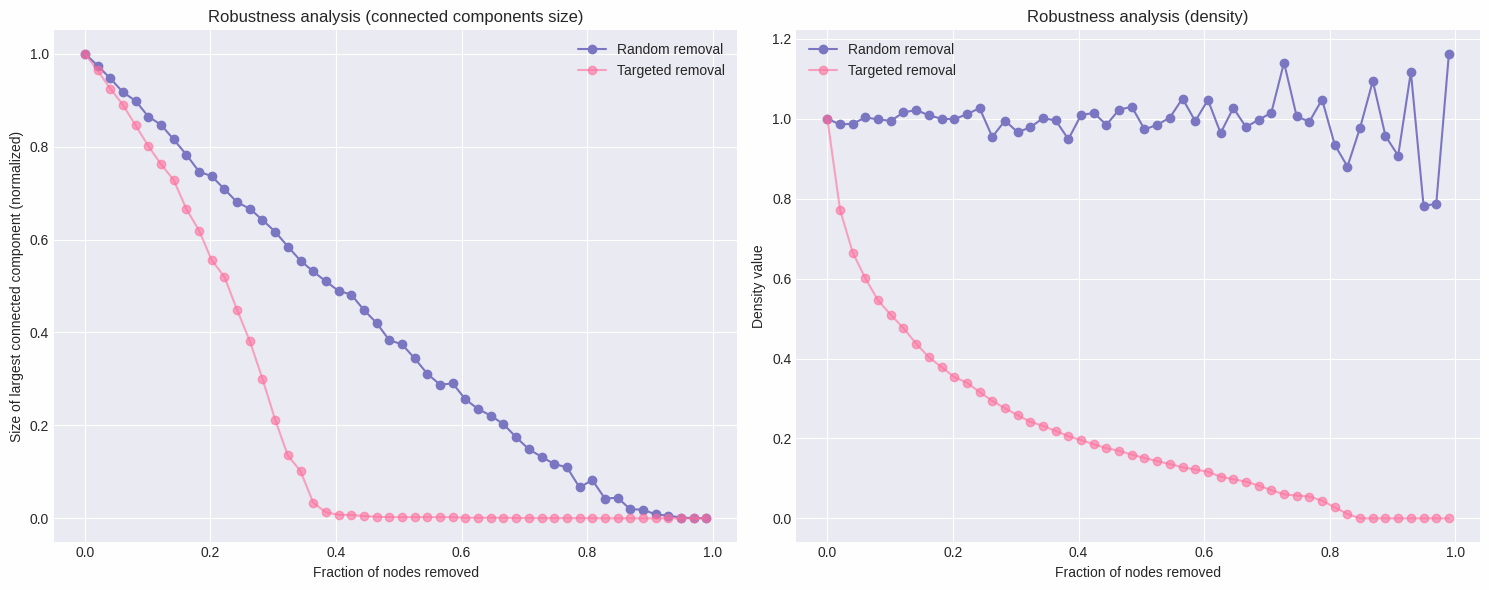

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# First plot
axs[0].plot(fractions, random_results_cc, '-o', label='Random removal')
axs[0].plot(fractions, targeted_results_cc, '-o', label='Targeted removal')
axs[0].set_xlabel('Fraction of nodes removed')
axs[0].set_ylabel('Size of largest connected component (normalized)')
axs[0].set_title('Robustness analysis (connected components size)')
axs[0].legend()

# Second plot
axs[1].plot(fractions, random_results_d, '-o', label='Random removal')
axs[1].plot(fractions, targeted_results_d, '-o', label='Targeted removal')
axs[1].set_xlabel('Fraction of nodes removed')
axs[1].set_ylabel('Density value')
axs[1].set_title('Robustness analysis (density)')
axs[1].legend()

plt.tight_layout()
plt.show()

# Cancer expression (Human Protein Altas)

In [31]:
# Make the filtering mask
# Select breast cancer rows which are prognostic and unfavorable (by setting a 5% p-value threshold and by removing NaNs) and with at least one record of high staining levels
high_thr = 1 # At least one record

remove_nans = pathology['prognostic - unfavorable'].notna()
significance = (pathology['prognostic - unfavorable'] < 0.05) & (pathology['High'] >= high_thr)
breast_cancer = pathology['Cancer'] == 'breast cancer'

mask = remove_nans & significance & breast_cancer

# Apply the mask
filt_pathology = pathology[mask].reset_index()

# Extract the breast-cancer related genes from the interactome graph
bc_genes = [gene for gene in filt_pathology["Gene name"].unique() if gene in set(nodes)]

# Add to this set the direct neighbors of each breast-cancer related gene (i.e., physical interaction target proteins or complexes)
subgraph = subgraph_of_nodes_and_neighbors(G, bc_genes, depth = 1)
neighs_enrich = list(subgraph.nodes())

# Look at their function and their neighbors to check whether they are hubs or not
neighs_enrich_df = degree_sort[degree_sort["Vertex"].isin(neighs_enrich)]

# Add UniProts ID for each gene
neighs_enrich_df = neighs_enrich_df.copy()
neighs_enrich_df.loc[:, "UniProt"] = neighs_enrich_df["Vertex"].apply(id_mapping_2.get)

# Reorder the columns
neighs_enrich_df = pd.DataFrame(neighs_enrich_df[["Vertex", "UniProt", "Degree", "Function"]])

# Select breast cancer-related genes that are also hubs
bc_hubs_enrich = neighs_enrich_df[neighs_enrich_df["Degree"] >= degree_thr]

# Remove the nodes that the mapping did not find
bc_hubs_enrich = bc_hubs_enrich.dropna()

# Extract breast cancer-related proteins for GO enrichment against all Swiss-Prot
bc_proteins_hubs_enrich = bc_hubs_enrich["UniProt"].values # Selected only if they are hubs

In [32]:
print("Top 10 breast cancer-related hubs")
bc_hubs_enrich.head(10)

Top 10 breast cancer-related hubs


,Vertex,UniProt,Degree,Function
31,RPS27A,P62979,255,3315 Ubiquitin-40S ribosomal protein S27a; ...
32,UBA52,P62987,235,14217 Ubiquitin-60S ribosomal protein L40; ...
29,UBC,P0CG48,172,16612 Polyubiquitin-C; [Ubiquitin]: Exists ...
28,UBB,P0CG47,168,17959 Polyubiquitin-B; [Ubiquitin]: Exists ...
1042,H3C13,Q71DI3,158,7457 Histone H3.2; Core component of nucleo...
2252,RPS23,P62266,139,4561 40S ribosomal protein S23; Component o...
1043,H3C12,P68431,132,9156 Histone H3.1; Core component of nucleo...
1418,RPS28,P62857,127,17673 Ribosomal protein S28; Belongs to the...
501,RBX1,P62877,112,"374 E3 ubiquitin-protein ligase RBX1, N-ter..."
1036,H3-3B,P84243,103,1763 Histone H3.3; Variant histone H3 which...


# Communities and modularity

In [33]:
G_enrich = G.subgraph(bc_hubs_enrich["Vertex"].values)
G_enrich = subgraph

# Label Propagation for communities detection
modules = list(nx.algorithms.community.label_propagation.label_propagation_communities(G_enrich))
modules = {i + 1 : community for i, community in enumerate(modules)} # Index modules

module_lengths_df = pd.DataFrame([(key, len(value)) for key, value in modules.items()], columns=['Module number', 'Length']).sort_values("Length", ascending = False)

# Select most populatd modules
top = 5

best_modules = {module_num : modules[module_num] for module_num in module_lengths_df.iloc[:top, 0].values}

<ipython-input-34-c212fe0cac29>:22: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Subgraph degree')


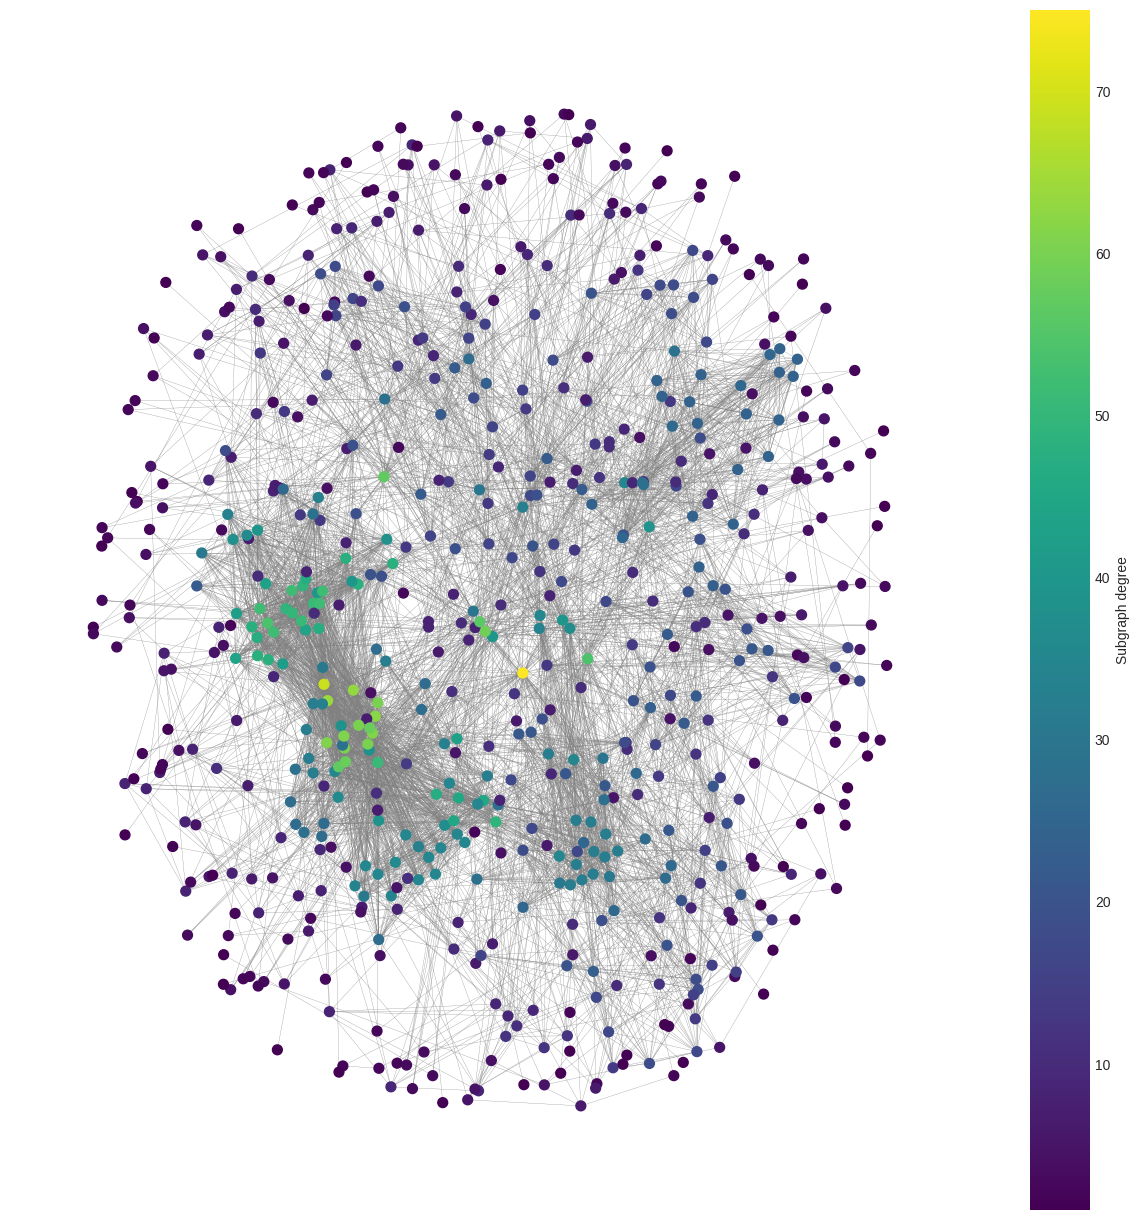

In [34]:
# Subgraph Plot
degrees = dict(G_enrich.degree())
degree_values = list(degrees.values())

cmap = plt.cm.viridis
norm = mcolors.Normalize(vmin=min(degree_values), vmax=max(degree_values))
node_colors = [cmap(norm(degree)) for degree in degree_values]

pos = nx.spring_layout(G_enrich, k=0.5)

plt.figure(figsize=(12, 12))

nx.draw(G_enrich, pos,
        node_size=50,
        node_color=node_colors,
        edge_color='gray',
        width=0.2,
        with_labels=False)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='Subgraph degree')

plt.show()

# Functional enrichment

In [35]:
# Instantiate the GO enrichment study
obj = GOEnrichmentStudy(
    swiss_prots, gene2go, obodag,
    propagate_counts = True,
    relationship = {'is_a'},
    #relationship = {'regulates', 'negatively_regulates', 'positively_regulates'},
    alpha = 0.05,
    methods = ['fdr_bh'])

# Perform the enrichment for each selected module
for key, module in best_modules.items():
    prot_module = [id_mapping_2[gene] for gene in module if id_mapping_2.get(gene)]
    goea_results_all = obj.run_study(prot_module)
    obj.wr_tsv("go_enrichment_results_{}.tsv".format(key), goea_results_all)

results = dict()

for key, module in best_modules.items():
    # Select only significant results
    all_results = pd.read_csv("go_enrichment_results_{}.tsv".format(key), sep = "\t")
    significant_results = all_results[all_results["p_fdr_bh"] < 0.05]

    results[key] = significant_results

# Transform the proteins row from str to list
for key in results:
    df_copy = results[key].copy()
    df_copy.loc[:, "study_items"] = df_copy["study_items"].apply(lambda prots: prots.split(", "))
    results[key] = df_copy

# Select, among breast cancer hubs containing protein complexes, only the proteins that are less studied
tdl_all = {node : tdl[node] for node in nx.relabel_nodes(G_enrich, id_mapping_2) if tdl.get(node)} # Just for G_enrich proteins
all_labels = set(tdl_all.values())

tdl_bio = [key for key, value in tdl_all.items() if value == "Tbio"] # Targets that do not have known drug or small molecule activities
tdl_dark = [key for key, value in tdl_all.items() if value == "Tdark"] # Targets proteins about which virtually nothing is known

points = {'Tdark' : 1, 'Tbio': 0.5, 'Tchem' : 0.25, 'Tclin' : 0}

for result in results.values():
    result["rls"] = result["study_items"].apply(lambda prots: sum(points[tdl_all.get(prot, 0)] for prot in prots) / len(prots) if prots else 0)

all_result = pd.DataFrame()

for result in results.values():
    all_result = pd.concat([all_result, result], ignore_index = True)

final_selection = all_result[(all_result["rls"] >= 0.75) & (all_result["p_fdr_bh"] <= 0.05)].sort_values("rls", ascending = False)


Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
  3% 17,520 of 570,420 population items found in association

Runing  Ontology Analysis: current study set of 79 IDs.
100%     79 of     79 study items found in association
100%     79 of     79 study items found in population(570420)
Calculating 15,029 uncorrected p-values using fisher_scipy_stats
  15,029 terms are associated with 17,520 of 570,420 population items
   1,552 terms are associated with     79 of     79 study items
  METHOD fdr_bh:
     935 GO terms found significant (< 0.05=alpha) (935 enriched +   0 purified): statsmodels fdr_bh
      79 study items associated with significant GO IDs (enriched)
       0 study items associated with significant GO IDs (purified)
  15029 items WROTE: go_enrichment_results_3.tsv

Runing  Ontology Analysis: current study set of 74 IDs.
100%     74 of     74 study items found in association
100%     74 of     74 study items found in population(570420)
Calculating 15,029

In [36]:
print("top 10 understudied functional groups")
final_selection.head(10)

top 10 understudied functional groups


,# GO,NS,enrichment,name,ratio_in_study,ratio_in_pop,p_uncorrected,depth,study_count,p_fdr_bh,study_items,rls
3969,GO:1990683,BP,e,DNA double-strand break attachment to nuclear ...,1/64,2/570420,2.243837e-04,5,1,4.301355e-03,[Q0D2I5],1.000000
4102,GO:0097240,BP,e,chromosome attachment to the nuclear envelope,1/64,7/570420,7.851260e-04,4,1,1.289580e-02,[Q0D2I5],1.000000
4974,GO:0018342,BP,e,protein prenylation,1/43,11/570420,8.289084e-04,6,1,2.204896e-02,[Q7Z6K3],1.000000
4977,GO:0097354,BP,e,prenylation,1/43,11/570420,8.289084e-04,3,1,2.204896e-02,[Q7Z6K3],1.000000
5097,GO:0043604,BP,e,amide biosynthetic process,41/42,393/570420,1.123887e-129,5,41,3.378179e-126,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
5093,GO:0032543,BP,e,mitochondrial translation,41/42,94/570420,1.059989e-158,8,41,1.593057e-154,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
5094,GO:0006412,BP,e,translation,41/42,241/570420,5.178900e-139,7,41,3.891684e-135,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
5095,GO:0043043,BP,e,peptide biosynthetic process,41/42,269/570420,6.978283e-137,6,41,3.495887e-133,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
5096,GO:0006518,BP,e,peptide metabolic process,41/42,363/570420,3.598345e-131,4,41,1.351988e-127,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
5098,GO:0043603,BP,e,amide metabolic process,41/42,649/570420,2.295948e-120,3,41,5.750967e-117,"[O75394, P09001, P49406, P52815, Q13084, Q1340...",0.804878
